##### Sensitivity Analysis Results of the effect of Energy Producer Maximum outPut on the Voltage Rise Detected 

Simulation are done in [SensAnalysisP0100](SensAnalysisP0100.ipynb) 
* Prediction block RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 
* RObust RNN To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on robust Model1 and Model 3 [2021_2022_RNN_Robust_All_Models](2021_2022_RNN_Robust_All_Models.ipynb))
* Prediction Block Future Known [2021_2022_KnownFuture](2021_2022_KnownFuture.ipynb)
* Persistence Model [2021_2022_Persistence](2021_2022_Persistence.ipynb)



Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

#### Import Modules 


In [969]:
import pandas as pd
# import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pickle, sys, importlib
import joblib
import dill 
import os
from scipy import ndimage


##### My own modules and functions

In [13]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

#### Import Simulation results from Simumlation done in [SensAnalysisP0100Machine2](SensAnalysisP0100_Machine2.ipynb)

In [630]:
persFolder = 'pickle_files/simulationResults/SensAnalysis/Pers/' # Folder name
futureKnownFolder = 'pickle_files/simulationResults/SensAnalysis/FutureKnown/' # Folder name
rnnFolder = 'pickle_files/simulationResults/SensAnalysis/RNN/' # Folder name

##### Persistence

In [771]:
os.listdir(persFolder)[0].split('_',)

['Pers', 'btRangeIndex', '0.plk']

In [966]:
class SensAnlysisResults:
    
    
    def __init__(self, folder_location):
        self.folder_location = folder_location
        self.files_in_folder_list = os.listdir(self.folder_location) 
        self.files_in_folder_list = self.__sort_files_in_folder__()
        # self.res_df = pd.DataFrame()
        
        
    def __sort_files_in_folder__(self):
        first_file_in_folder_name = self.files_in_folder_list[0]
        
        # Separate first file in folder name
        self.prediction_model_name, bt_range_name, _ = first_file_in_folder_name.split('_')  
        
        # Create a new list spaning from 0 to the total number of element in files_in_folder_list
        files_in_folder_list_out = [ self.prediction_model_name+'_'+bt_range_name+'_'+str(elm)+'.plk' 
                                    for elm in range(len(self.files_in_folder_list))]
        
        return files_in_folder_list_out
          
        
    def in_data_frame(self): 
        res_dict = {} # Dictionary to save variables
        
        for curFileName in self.files_in_folder_list:
            cur_file_data = joblib.load(self.folder_location+curFileName)  # Load files
            cur_file_data_keys_list =list(cur_file_data.keys())            # Get keys names in the current file
            energy_curt_list  = []                                         # Create an energy list 

            for cur_key in cur_file_data_keys_list:  # for each element in the loaded dictionary
                data_df = cur_file_data[cur_key]['Power Sgen']
                
                # data_df.iloc[:,0] => Power injected when there is  no control
                # data_df.iloc[:,1] => Power injected using current controler
                power_curt = (data_df.iloc[:,0] - data_df.iloc[:,1]).sum()         
                energy_curt_list.append( power_curt*Δt ) 
                
                
            col_name = cur_file_data_keys_list[0].split()[0] 
            res_dict.update({col_name: energy_curt_list})
           
        # Create index name for the resulting dataframe
        df_index = [key.split()[1].split('=')[1] for key in cur_file_data_keys_list]
        
        # Crete resulting dataframe
        self.res_df = pd.DataFrame(res_dict, index=df_index)
        
#         # Rename column of  resulting dataframe
#         self.res_df.columns = [elm.split('=')[1] for elm in self.res_df.columns]
         
        return self.res_df
    
    
    
    
    
    
    def print_sorted_filesNames(self, ): 
        print(self.files_in_folder_list)

    
    def plot_heatmap(self, fig_params=None, 
                     contour_color='yellow', 
                     contour_level=np.arange(0,700,100), 
                     colmap='twilight'  ):
        
        # Check whether res_df is already defined i.e self.in_data_frame() 
        # is already executed once. If yes, thre is no exception, otherwise
        # execute the funcction
        try:
            getattr(self,'res_df')   
        except AttributeError:
            print()
            self.res_df = self.in_data_frame()
        
        # if fig_params is not given plot the heatmap in a new figure otherwise fig_params must 
        # be an axe from plt.subplots()
        # TODO Verify if fig_params is actualy an axe and issue an error in the contrary
        if fig_params == None:
            fig, axx = plt.subplots(figsize=(10,6), dpi=100)
        else:
            axx = fig_params
            

        x_contours = range(len(self.res_df.columns))
        y_contours = range(len(self.res_df.index))
        
        cntr = axx.contour(x_contours, y_contours, 
                           self.res_df.iloc[::-1,:],
                           levels = contour_level,
                           colors=contour_color,
                           linewidths=1 ) 
        # Contourlables
        axx.clabel(cntr, fmt='%1.0f',inline_spacing=10,fontsize=10)
        
        # colorbar kwargs 
        clbar_kwargs = dict (label = "Curtailed Energy (MWh/Year)", anchor=(0,.5), shrink=0.7)
        
        # anotation kwargs
        annot_kw = dict(size=8)
        
        # actual plot()
        sbn.heatmap(res_df.iloc[::-1,:],
                    ax=axx, 
                    annot_kws=annot_kw,
                    fmt='.0f', 
                    lw=0., 
                    cbar_kws=clbar_kwargs, 
                    cmap=colmap)
        
        # axx collection[7] contains the colorbar
        axx.collections[7].colorbar.add_lines(cntr)
        

        axx.set( 
            xlabel ='BT Production increase Variation (Mwh)', 
            ylabel ='P0100 Maximum Prod (MWh)', 
            title = self.prediction_model_name );



In [967]:
persistence, futureKnown = map(SensAnlysisResults, [persFolder,futureKnownFolder])
persistence.in_data_frame(), futureKnown.in_data_frame();

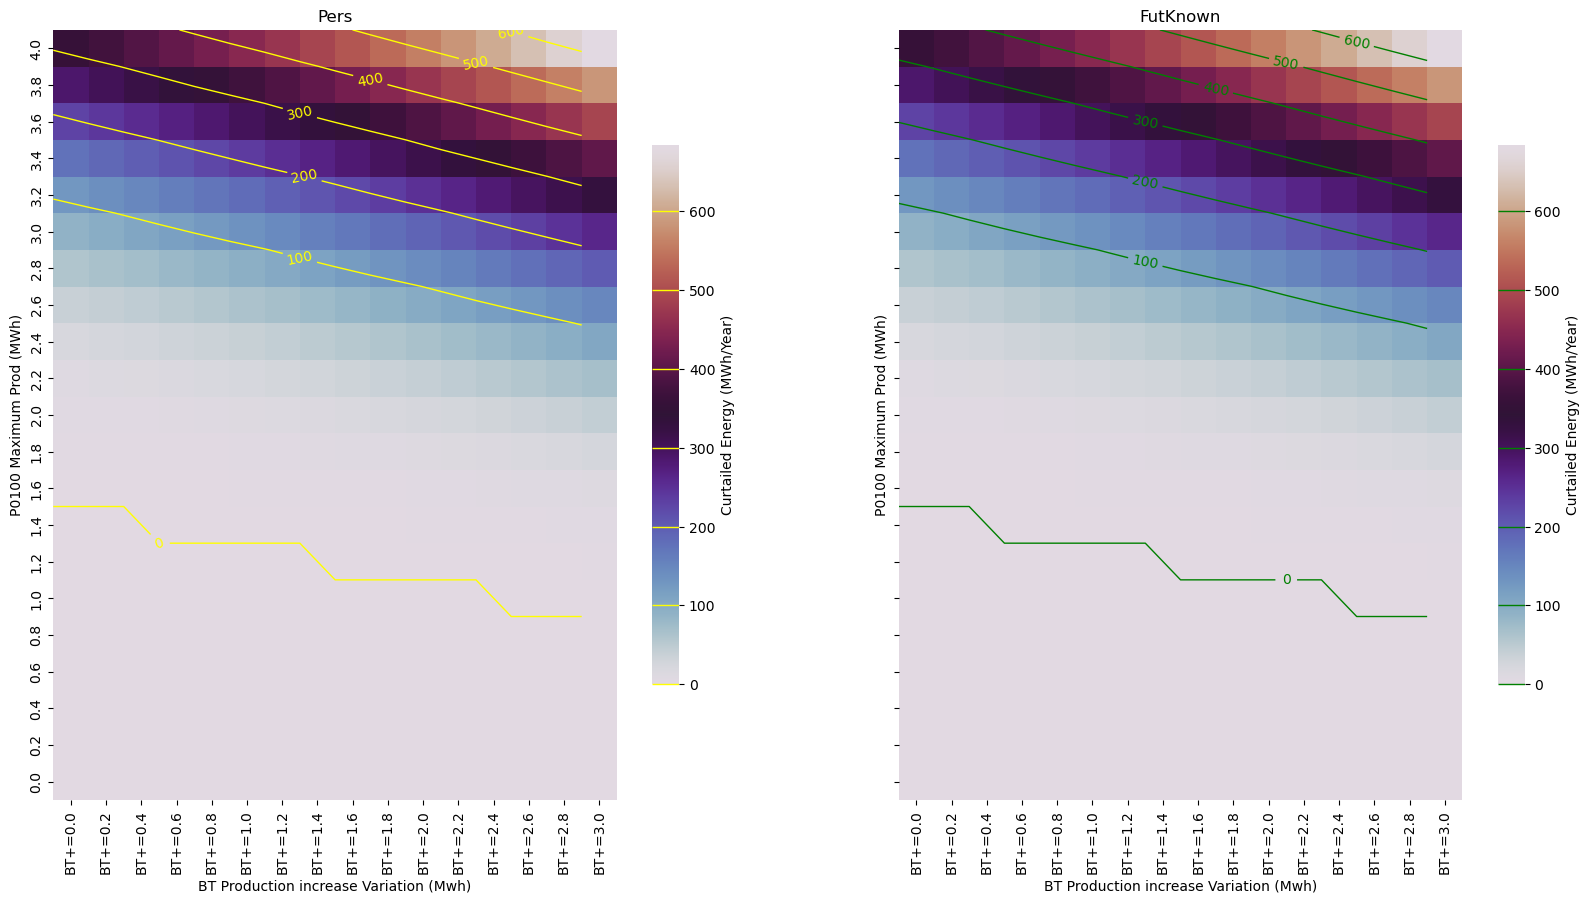

In [968]:
fig, axx = plt.subplots(1,2, figsize=(20,10), sharey=True)
persistence.plot_heatmap(fig_params=axx[0])
futureKnown.plot_heatmap(fig_params=axx[1],contour_color='green')

In [932]:
# al.in_data_frame()


In [929]:
# al.plot_heatmap()

try:
    getattr(al,'in_data_frame')
except AttributeError : 
    print('noday')


In [723]:
new_dict = {}
new_dict.update({"a":10})
new_dict

{'a': 10}

In [750]:

files_in_folder_list = os.listdir(rnnFolder) # Get names of files in the folder

res_dict = {}

# Load the results saved in each file, compute the curtailed energy and save it in res_dict
for cur_index, curFileName in enumerate(files_in_folder_list[1:]): 
    
    cur_fileData = joblib.load(rnnFolder+curFileName)    
    dictKeysNames_list = [elm for elm in cur_fileData if elm.split()[0] == 'BT+=3.0']
    new_dict={}
    
    for cur_key in dictKeysNames_list:
        new_key_name = 'BT+='+beg_name[cur_index]+' '+cur_key.split()[1]
        new_dict.update({new_key_name:cur_fileData[cur_key] })

    joblib.dump(new_dict,RnnFolder+'rnn/'+curFileName)
# # df_index = [elm.split()[1].split('=')[1] for elm in dictKeysNames_list]
# res_df = pd.DataFrame(res_dict)

# # res_df.columns = [elm.split('=')[1] for elm in res_df.columns]

In [1094]:
flg = res_df.iloc[::-1,:]

smooth_scale = 3
z = np.round(ndimage.zoom(flg.to_numpy(), smooth_scale), decimals=1)


In [1095]:
# ndimage.zoom(flg.to_numpy(),2)

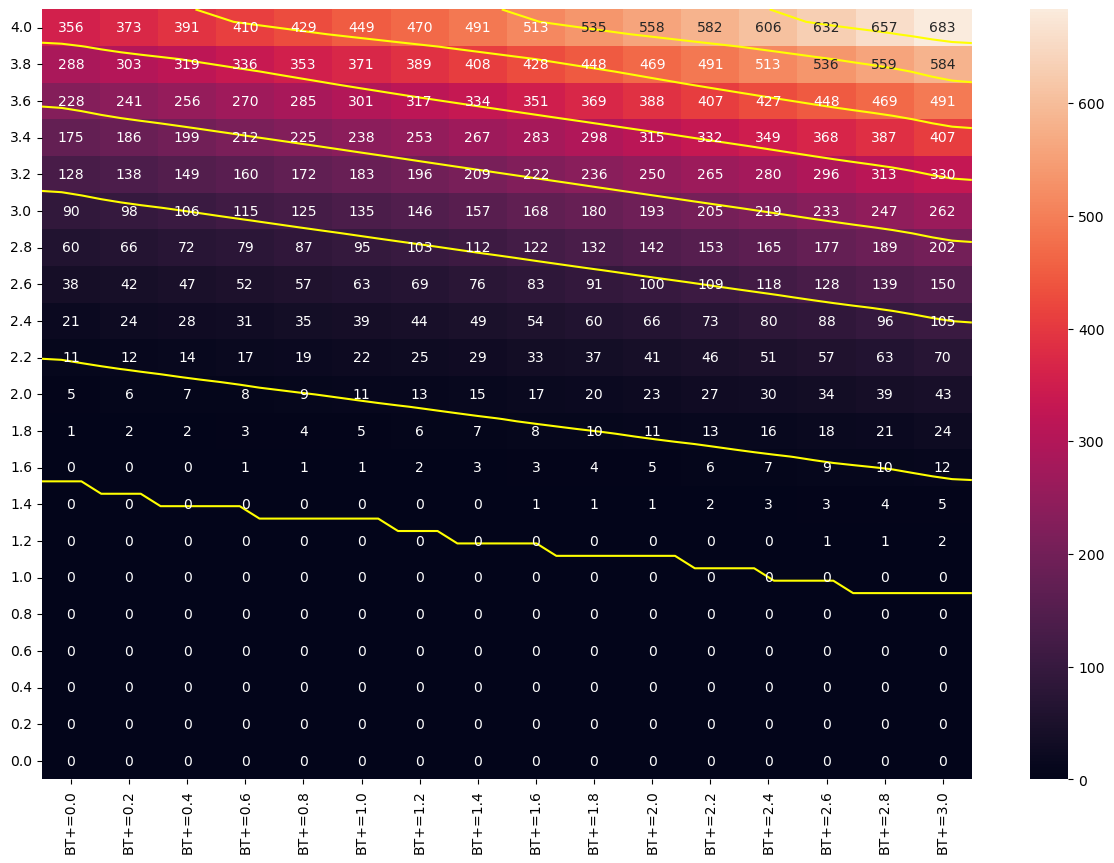

In [1099]:
fig, axx = plt.subplots(figsize=(15,10))
sbn.heatmap(flg, annot=True, fmt='.0f')
plt.yticks(rotation=0);
x_cont = np.linspace(0, len(flg.columns), len(flg.columns)*smooth_scale)
y_cont = np.linspace(0, len(flg.index), len(flg.index)*smooth_scale)

lev = [0, 10,]
[lev.append(elm) for elm in range(100,700, 100)]
ctr = axx.contour(x_cont, y_cont, z, lev, colors='yellow')

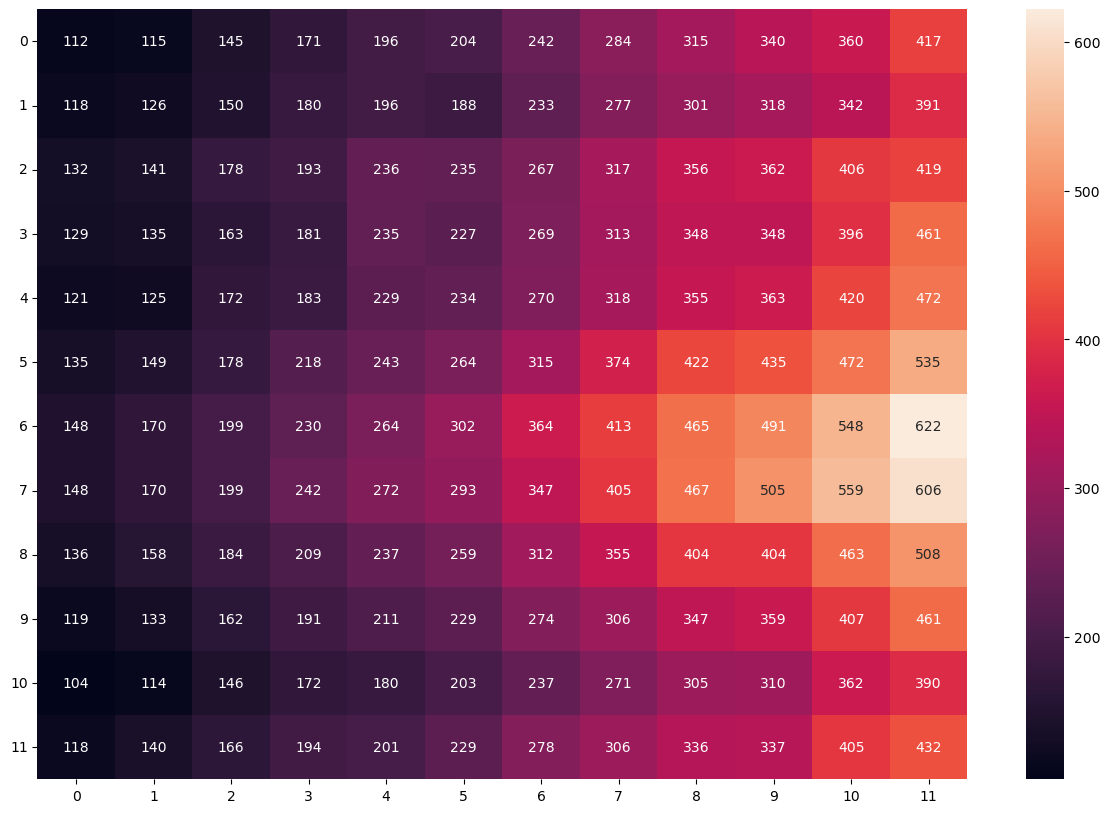

In [1003]:
plt.figure(figsize=(15,10))
sbn.heatmap(ndimage.zoom(flg.to_numpy(),1), annot=True, fmt='d')
plt.yticks(rotation=0);

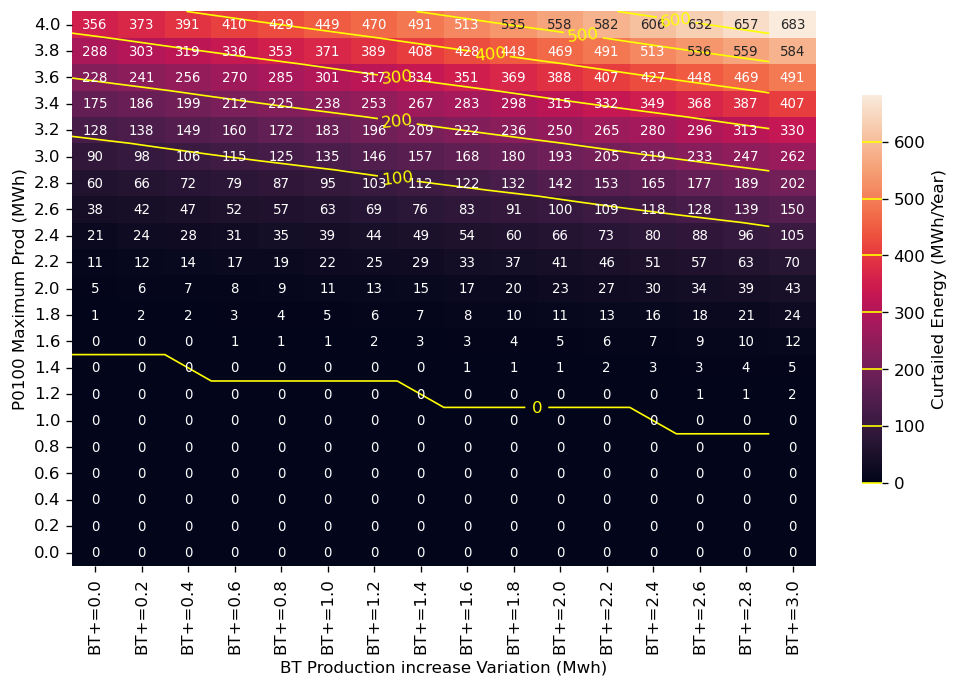

In [1010]:
fig, axx = plt.subplots(figsize=(10,6), dpi=120)


z = ndimage.zoom(res_df.iloc[::-1,:].to_numpy(), 1)


cntr = axx.contour(range(16), 
                   range(21), res_df.iloc[::-1,:],
                   np.arange(0,700,100),
                   colors='yellow',linewidths=1 ) 

axx.clabel(cntr, fmt='%1.0f',inline_spacing=10,fontsize=10)

clbar_kwargs = dict (label = "Curtailed Energy (MWh/Year)", anchor=(0,.5), shrink=0.7)
annot_kw = dict(size=8)
sbn.heatmap(res_df.iloc[::-1,:],
            ax=axx, 
            annot=True,
            annot_kws=annot_kw,
            fmt='.0f', 
            lw=0., 
            cbar_kws=clbar_kwargs, )


axx.collections[7].colorbar.add_lines(cntr)

axx.set( 
        xlabel ='BT Production increase Variation (Mwh)', 
        ylabel ='P0100 Maximum Prod (MWh)', );

# plt.xticks(np.arange(0,16), labels=np.round(np.arange(0,3.2,0.2), decimals=2));
# plt.yticks(np.arange(21,0,-1), labels=np.round(np.arange(0,4.2,0.2), decimals=2));

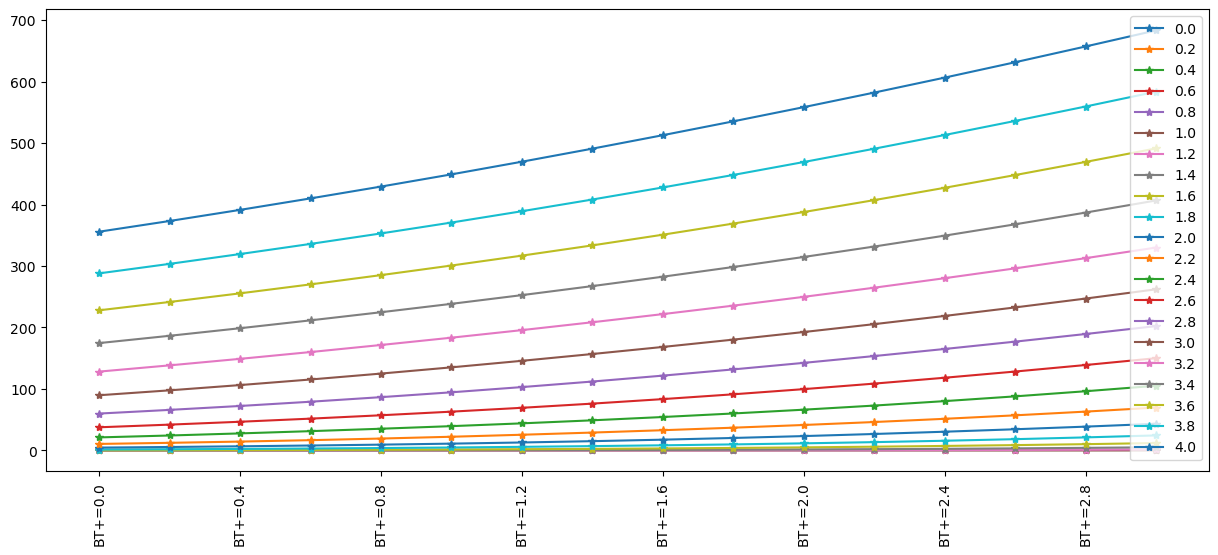

In [1039]:
fig, axx = plt.subplots(figsize=(15,6))
res_df.T.plot( ax=axx, marker='*')
plt.xticks(rotation=90);

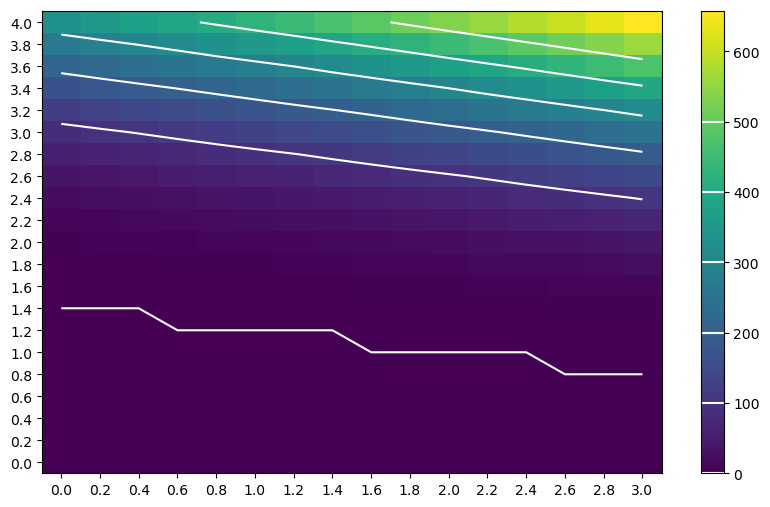

In [431]:
fig, axx = plt.subplots(figsize=(10,6))

figg = axx.imshow(pd.DataFrame(res_df, index=df_index),origin='lower', aspect='auto', )

clbar = plt.colorbar(figg, )
ctnr = plt.contour(res_df, range(0,600,100) ,colors='w')

axx.clabel(cntr,range(0,600,100))
plt.xticks(np.arange(0,16), labels=np.round(np.arange(0,3.2,0.2), decimals=2), ma='left');
plt.yticks(np.arange(0,21,1), labels=np.round(np.arange(0,4.2,0.2), decimals=2));

clbar.add_lines(ctnr)

#### Create daily mask

In [4]:
int_var = fut_known['Sim1']['Power Sgen']
mask = int_var.index.to_timestamp().to_series().between_time('08:10','18:30').index.to_period('10T')

#### Data Reshaping

In [5]:
# Get all the predictor in a list
predictor_list = [fut_known, rnn_pred, rnn_pred_rob1, rnn_pred_rob3, pers_pred_rob]
comb_list ,comb_list_event = [],[]


# Create a list for each variable  (Energy and voltage rise) we're interested in for each predictor considered
fut_known_energyList, fut_known_vRiseList = [], []
rnn_pred_energyList, rnn_pred_vRiseList = [], []
rnn_pred_rob1_energyList, rnn_pred_rob1_vRiseList = [], []
rnn_pred_rob3_energyList, rnn_pred_rob3_vRiseList = [], []
pers_pred_rob_energyList, pers_pred_rob_vRiseList = [], []


# Collect all the same type of variable in a list
predictor_energyList = [fut_known_energyList, rnn_pred_energyList, rnn_pred_rob1_energyList, rnn_pred_rob3_energyList, pers_pred_rob_energyList]
predictor_vRiseList = [fut_known_vRiseList, rnn_pred_vRiseList, rnn_pred_rob1_vRiseList, rnn_pred_rob3_vRiseList, pers_pred_rob_vRiseList]




for cur_sim in list(fut_known.keys())[1:]:  # For each simulation ['Sim1', 'Sim2' .... , 'Sim20']
   
    int_var_events = [] # " Intermediate variables"
    int_var = []
    
    # Get the power of P0100 when no control is applied for each instant for the current simulation
    var_no_control_curSim =  fut_known[cur_sim]['Power Sgen']['No_Control'].loc[mask]
    
    for cur_indx, cur_predictor in enumerate(predictor_list):  # For each model to consider
        
        # Extract Power variables for the current predictor 
        var_no_control, var_curPredictor = cur_predictor[cur_sim]['Power Sgen'].loc[mask].sum()*Δt 
        
        # Save variables
        predictor_energyList[cur_indx].append([var_no_control, var_curPredictor, var_curPredictor*100/var_no_control])
                
        # Save The total Energy of the current predictor
        int_var.append(var_curPredictor)
        
        # Substract the no conrolled power of P0100 from the controlled  with the current predictor to get positive values 
        # When their are different
        var2 = var_no_control_curSim - cur_predictor[cur_sim]['Power Sgen'].loc[mask].iloc[:,-1]
        
        # Save the total number of instants where the power with no control > to that of the current predictor
        int_var_events.append((var2>0).sum())

        
        if cur_indx != 0 :
            var  = cur_predictor[cur_sim]['maxV_rise_df'].loc[mask]
            vRise_thresholded = var[var>1.025]
            predictor_vRiseList[cur_indx].append(vRise_thresholded)

    # Add element to list
    comb_list_event.append(int_var_events) 
    comb_list.append([var_no_control-elm for elm in int_var])

In [36]:
predictor_energyList[0][-1],predictor_energyList[1][-1], predictor_energyList[2][-1], predictor_energyList[3][-1], predictor_energyList[4][-1]

([5060.71, 4704.867870432496, 92.9685334751941],
 [5060.71, 4442.248634046482, 87.77915814276025],
 [5060.71, 4755.334792982472, 93.96576355852187],
 [5060.71, 4734.939122988595, 93.56274362665702],
 [5060.71, 4724.882630191528, 93.3640265929391])

#### Plot Variation of the yearly curtailed energy function of  P0100 output

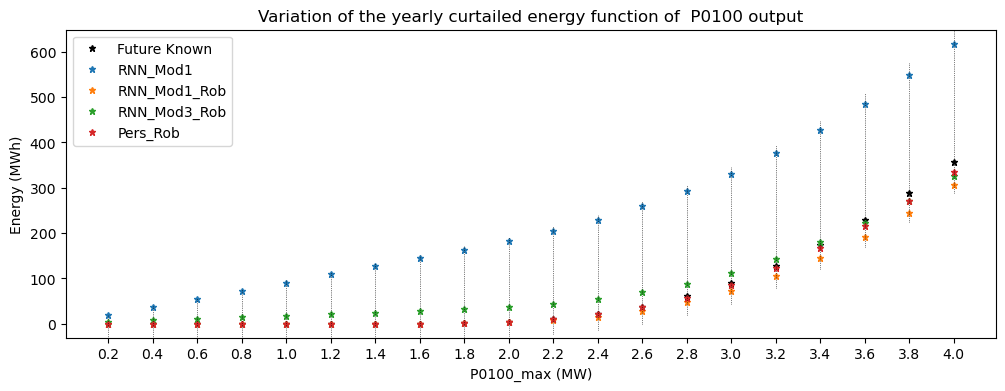

In [6]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']
P0100_max = 4
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)
# p0100_maxRange = np.round(P0100_max_range[1:], decimals=2) # Create range for each value of P0100_max

fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list).shape[1]): 
    axx.plot(np.array(comb_list)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks(range(20), labels=np.round(P0100_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Energy (MWh)', xlabel = 'P0100_max (MW)')
axx.set_title("Variation of the yearly curtailed energy function of  P0100_max output")


for rows in range(20):
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.5, color='k', ls=':')

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
plt.legend(model_names)

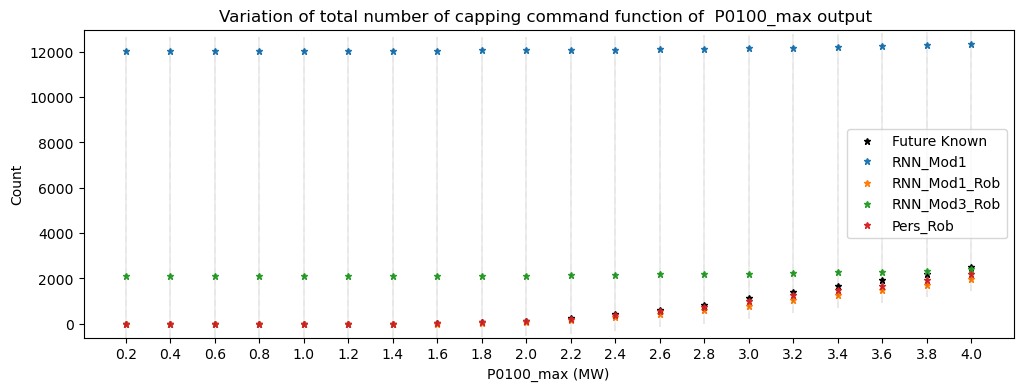

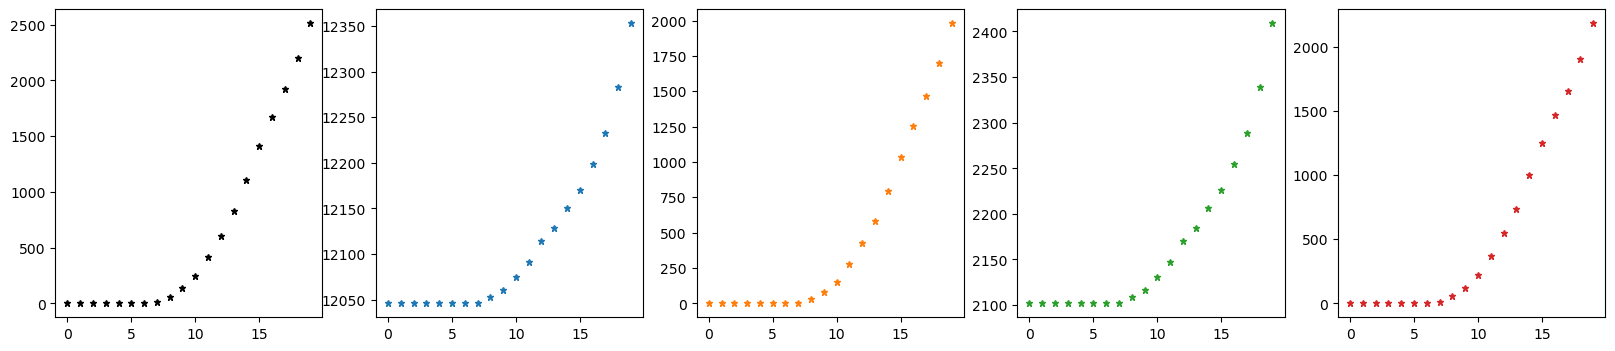

In [14]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']
P0100_max = 4
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)
# p0100_maxRange = np.round(P0100_max_range[1:], decimals=2) # Create range for each value of P0100_max

fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list_event).shape[1]): 
    axx.plot(np.array(comb_list_event)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks(range(20), labels=np.round(P0100_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list_event).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Count', xlabel = 'P0100_max (MW)')
axx.set_title("Variation of total number of capping command function of  P0100_max output ")

for rows in range(20):
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.3, color='k', ls=':')

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
plt.legend(model_names)



fig, axx = plt.subplots(1,5, figsize=(20,4))
for elm, cur_ax in zip(range(np.array(comb_list_event).shape[1]), axx.flatten()): 
    cur_ax.plot(np.array(comb_list_event)[:,elm].round(decimals=2), ls='', marker='*', markersize=5,color=color_list[elm])

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
# fig.legend(model_names, bbox_to_anchor=(0.22,0.8))

##### How can one explain the behavior of the RNN_Mod3_Rob
It is important to notice that the Robust RNN model 3 which predicts voltage rise values has been trained with data provided by P0100_max = 4MWh. We assume that the parameters learn in this specific training case do not generalize for lower values of P0100_max which could explain why the total number of capping command is higher than that of the other controller

<div class = 'alert alert-block alert-info' >
<b> TODO:</b>
    Train a new RNN for each P0100_max
</div>

#### Reshape data into dataframe to do a categorical Plot

In [16]:
df2usev= pd.DataFrame(columns=['V_rise','Model', 'Power']) # Create empty dataframe with following collumns
p0100_maxRange = np.round(P0100_max_range[1:], decimals=2)

for cur_predictor_ind in range(1,5): # For the current model_index
    for p_max_ind in range(20): # For each value of P0100_max
        
        # Create a dataframe of voltage rise
        df = pd.DataFrame(predictor_vRiseList[cur_predictor_ind][p_max_ind].dropna().values, columns=['V_rise'])
        
        # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
        df[['Model', 'Power']] = model_names[cur_predictor_ind], p0100_maxRange[p_max_ind]
        
        df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe

        
        
# Add values for the No control model to the previous created dataframe        
for cur_index, cur_sim in enumerate(list(fut_known.keys())[1:]): 
    # Extract values of voltage rise when no control and apply mask to.
    var = fut_known[cur_sim]['maxV_rise_pf_df'].loc[mask]
    
    # Create a dataframe using the thresholded values of the precedend var
    df = pd.DataFrame(var[var>1.025].dropna().values, columns=['V_rise'])
    
    # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
    df[['Model', 'Power']] = 'No_Control', p0100_maxRange[cur_index]
    
    df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe
    

#### Plot Categorical data

<span style='color:red'> Might be interesting to explain boxplots ([See figure](https://www.researchgate.net/publication/340996565/figure/fig3/AS:962186885210119@1606414638167/Box-plot-and-probability-density-function-of-a-normal-distribution.png) ) before showing off this pictures</span>




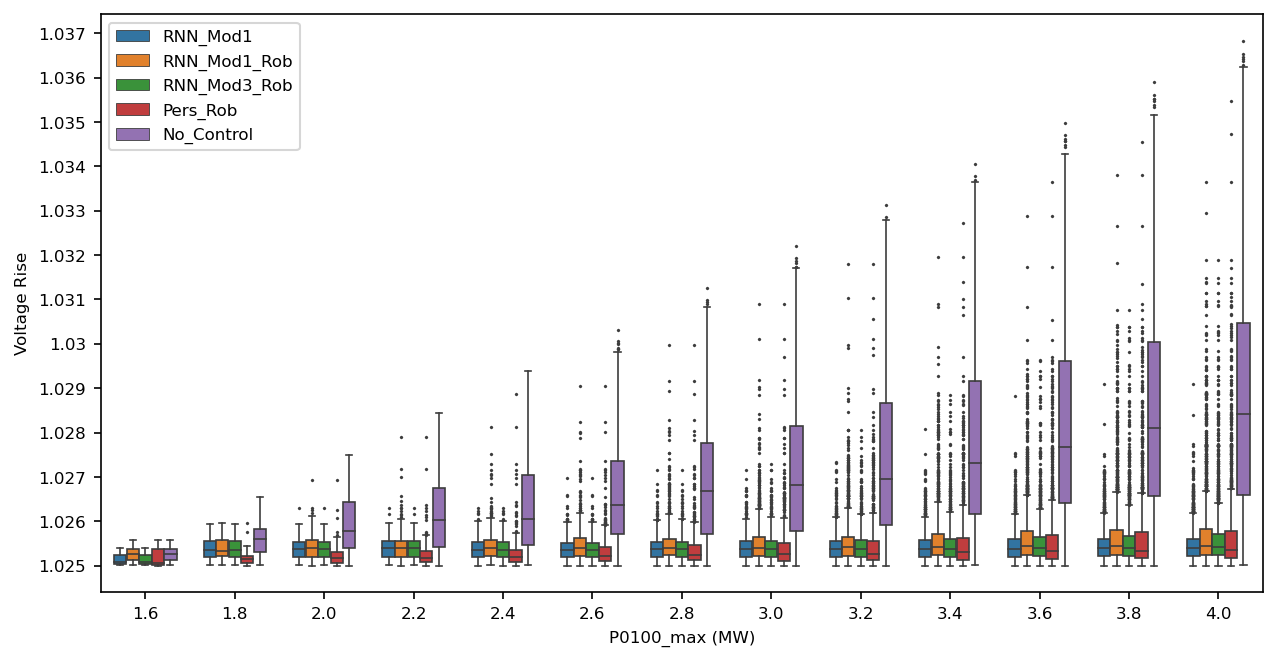

In [17]:
# filtered= df2usev[(df2usev["Model"] == 'RNN_Mod1') | (df2usev["Model"] == 'No_Control')]
flprop = dict(marker='x',)
fig, axx = plt.subplots(figsize=(10,5), dpi=150)
sbn.boxplot(x='Power', y='V_rise', data=df2usev, hue='Model', width=0.7, fliersize=1,linewidth=0.8, 
            flierprops=flprop, 
            
           )
lblsize = 8 
axx.set_xlabel('P0100_max (MW)', size=lblsize )
axx.set_ylabel('Voltage Rise', size=lblsize )
axx.set_xticklabels(p0100_maxRange[7:],size=lblsize )
axx.set_yticks(ticks=np.arange(1.025,1.037,0.001),
               labels=np.round(np.arange(1.025,1.037,0.001), decimals=3), size=lblsize)
axx.legend(fontsize=lblsize)

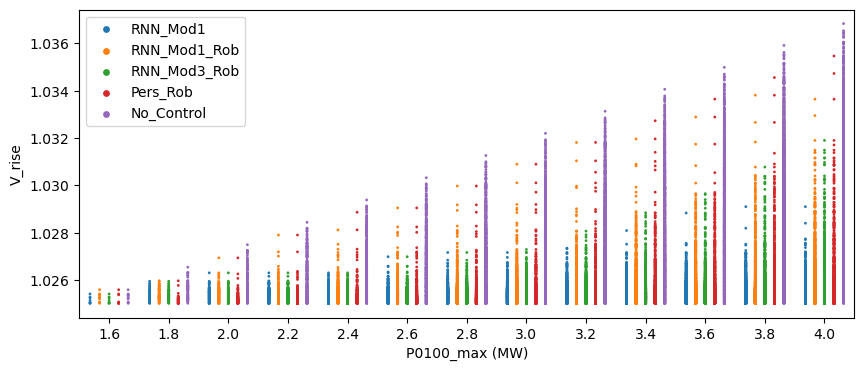

In [21]:
fig, axx = plt.subplots(figsize=(10,4), dpi=100)
sbn.stripplot(x='Power', y='V_rise', data=df2usev, hue='Model',ax=axx, size=2,  dodge=True,jitter=False)
axx.set( xlabel = 'P0100_max (MW)')
axx.legend(markerscale=0.5)

#### Get the Total number of event where the voltage rise is above defined threshold for each model

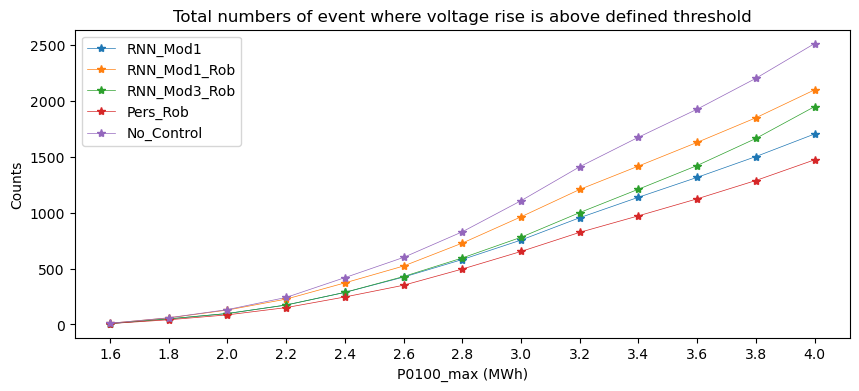

In [18]:
aa = pd.concat([df2usev.groupby(by=['Model', 'Power']).count().T[mod_name] for mod_name in df2usev.Model.unique()])
aa.index = df2usev.Model.unique()

fig, axx = plt.subplots(figsize=(10,4), dpi=100)
aa.T.plot(marker='*', lw=0.5, ax= axx)
plt.xticks(np.arange(1.6,4.1,0.2))
axx.set(xlabel='P0100_max (MWh)', ylabel='Counts', title='Total numbers of event where voltage rise is above defined threshold');